In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import ADASYN
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import models, layers

2024-08-12 16:43:03.111655: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-12 16:43:03.121133: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-12 16:43:03.210424: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-12 16:43:03.210518: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-12 16:43:03.226289: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [6]:
# Define constants
IMAGE_SIZE = 256
CHANNELS = 3
BATCH_SIZE = 32
EPOCHS = 20


In [7]:
# Load dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/home/dell/Desktop/chest_xray",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 5856 files belonging to 3 classes.


In [8]:
# Convert dataset to numpy arrays
def flatten_images(images, labels):
    images = tf.reshape(images, (-1, IMAGE_SIZE * IMAGE_SIZE * CHANNELS))
    return images.numpy(), labels.numpy()

X, y = [], []
for images, labels in dataset:
    X_batch, y_batch = flatten_images(images, labels)
    X.append(X_batch)
    y.append(y_batch)

X = np.concatenate(X)
y = np.concatenate(y)


In [9]:
# Apply ADASYN
adasyn = ADASYN()
X_resampled, y_resampled = adasyn.fit_resample(X, y)

In [10]:
# Reshape the resampled data back to the original image shape
X_resampled = np.reshape(X_resampled, (-1, IMAGE_SIZE, IMAGE_SIZE, CHANNELS))


In [11]:
# Convert the resampled data back to TensorFlow datasets
resampled_dataset = tf.data.Dataset.from_tensor_slices((X_resampled, y_resampled))

In [12]:
# Split dataset into train, validation, and test sets
train_size = int(0.7 * len(resampled_dataset))
val_size = int(0.15 * len(resampled_dataset))
test_size = len(resampled_dataset) - train_size - val_size

train_ds = resampled_dataset.take(train_size)
val_ds = resampled_dataset.skip(train_size).take(val_size)
test_ds = resampled_dataset.skip(train_size + val_size)


In [13]:
# Cache, shuffle, batch, and prefetch
train_ds = train_ds.cache().shuffle(1000).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
input_shape = ( IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3
model = models.Sequential([
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [15]:
# Compile the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [16]:
# Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    verbose=1
)

Epoch 1/20
188/188 [==============================] - 38s 201ms/step - loss: 1.0116 - accuracy: 0.6089 - val_loss: 0.5512 - val_accuracy: 0.8217
Epoch 2/20
188/188 [==============================] - 39s 205ms/step - loss: 0.6145 - accuracy: 0.7427 - val_loss: 0.3125 - val_accuracy: 0.9128
Epoch 3/20
188/188 [==============================] - 38s 204ms/step - loss: 0.5458 - accuracy: 0.7654 - val_loss: 0.8354 - val_accuracy: 0.6815
Epoch 4/20
188/188 [==============================] - 38s 203ms/step - loss: 0.5256 - accuracy: 0.7786 - val_loss: 0.1464 - val_accuracy: 0.9494
Epoch 5/20
188/188 [==============================] - 39s 205ms/step - loss: 0.5047 - accuracy: 0.7858 - val_loss: 0.4328 - val_accuracy: 0.8637
Epoch 6/20
188/188 [==============================] - 38s 205ms/step - loss: 0.4760 - accuracy: 0.7976 - val_loss: 0.1673 - val_accuracy: 0.9494
Epoch 7/20
188/188 [==============================] - 39s 206ms/step - loss: 0.4577 - accuracy: 0.8030 - val_loss: 0.2004 - val_ac

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [18]:
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

In [19]:
print("class distribution before ADASYN:", Counter(y))
print("****************")
print("class distribution after ADASYN:", Counter(y_resampled))

class distribution before ADASYN: Counter({0: 2780, 1: 1583, 2: 1493})
****************
class distribution after ADASYN: Counter({1: 3053, 0: 2780, 2: 2731})


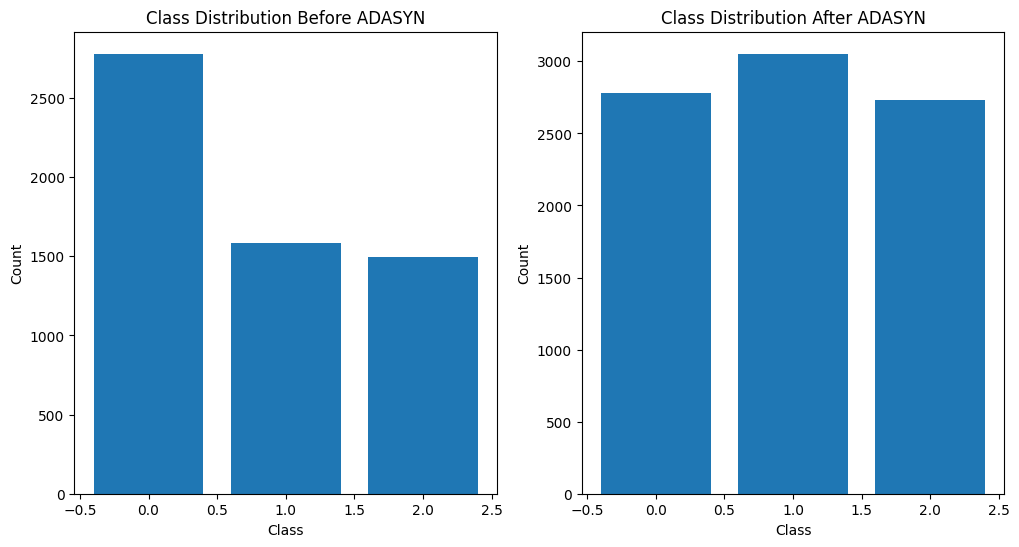

In [24]:


# Count the occurrences of each class
class_counts_before = Counter(y)
class_counts_after = Counter(y_resampled)

# Extract class labels and counts
classes_before = list(class_counts_before.keys())
values_before = list(class_counts_before.values())
classes_after = list(class_counts_after.keys())
values_after = list(class_counts_after.values())

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot before ADASYN
axs[0].bar(classes_before, values_before)
axs[0].set_title('Class Distribution Before ADASYN')
axs[0].set_xlabel('Class')
axs[0].set_ylabel('Count')

# Plot after ADASYN
axs[1].bar(classes_after, values_after)
axs[1].set_title('Class Distribution After ADASYN')
axs[1].set_xlabel('Class')
axs[1].set_ylabel('Count')

plt.show()


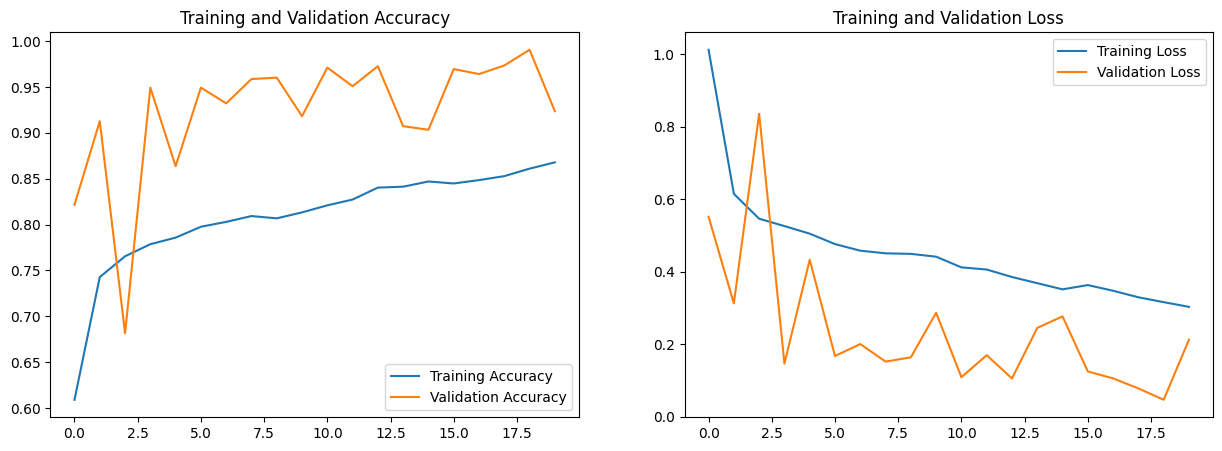

In [20]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
# Evaluate the model on the training dataset
train_loss, train_accuracy = model.evaluate(train_ds, verbose=1)
print(f"Train accuracy: {train_accuracy:.2f}")

# Evaluate the model on the validation dataset
val_loss, val_accuracy = model.evaluate(val_ds, verbose=1)
print(f"Validation accuracy: {val_accuracy:.2f}")

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_ds, verbose=1)
print(f"Test accuracy: {test_accuracy:.2f}")


188/188 [==============================] - 9s 46ms/step - loss: 0.2846 - accuracy: 0.8822
Train accuracy: 0.88
41/41 [==============================] - 2s 46ms/step - loss: 0.2123 - accuracy: 0.9237
Validation accuracy: 0.92
41/41 [==============================] - 2s 46ms/step - loss: 0.7581 - accuracy: 0.6687
Test accuracy: 0.67


In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

In [23]:


# Get predictions from the model
y_true = []
y_pred = []

for images, labels in test_ds:
    predictions = model.predict(images, batch_size=BATCH_SIZE)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Convert lists to numpy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Generate confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=list(range(n_classes)))

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


1/1 [==============================] - 0s 48ms/step


NameError: name 'class_names' is not defined

<Figure size 1000x700 with 0 Axes>

In [47]:
report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n", report)


Classification Report:
               precision    recall  f1-score   support

 bact_pneumo       0.00      0.00      0.00         0
      normal       0.38      1.00      0.55        48
viral_pneumo       1.00      0.50      0.67      1238

    accuracy                           0.52      1286
   macro avg       0.46      0.50      0.41      1286
weighted avg       0.98      0.52      0.67      1286



/home/dell/CNN/py_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dell/CNN/py_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/dell/CNN/py_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
